In [ ]:
import cvxpy as cp
import numpy as np
%matplotlib inline

In [ ]:
def E_cover(domain, rects):
    A_domain = domain.w * domain.d
    A_rects = sum((r.w * r.d) for r in rects)
    return A_domain - A_rects

In [ ]:
a = np.random.randn(5)
b = np.random.randn(5)
a, b, a *b

In [ ]:
cp.matmul

In [ ]:
a = cp.Variable(4)
print(a.value)
dir(a)

In [ ]:
G.T @ G

In [ ]:
G.T == G

In [ ]:
GG

In [ ]:
G

In [ ]:
# Generate a random problema

np.random.seed(0)
m, n= 6, 6

A = np.random.rand(m, n)
A = A.T.dot(A)

GG = G.T.dot(G)

b = np.random.randn(m)

# Construct a CVXPY problem
x = cp.Variable(n, integer=True)
#objective = cp.Minimize(cp.sum_squares(A@x - b))

print(x.shape, n, GG.shape, np.zeros((n, n)).shape)

GGG = np.zeros((n, n))
GGG[0, 0] = 1
GGG[-1, -1] = 1
GGG += 1

objective = cp.Minimize(cp.quad_form(x, GGG))
prob = cp.Problem(objective)
prob.solve()

In [ ]:
GGG

In [ ]:
w = np.array([2, 2, 2])
d = np.array([3, 4, 5])

x = np.hstack((w, d))
I = np.eye(len(x))
G = np.vstack((I[3:], I[:3]))

0.5 * x.T.dot(G).dot(x)

In [ ]:
w, d

In [ ]:
np.dot(w, d)

In [ ]:
cp.dot

In [ ]:
import scipy.optimize

def solve_qp_scipy(G, a, C, b, meq=0, x_i=None):
    # Minimize     1/2 x^T G x - a^T x
    # Subject to   C.T x >= b
    def f(x):
        return abs(200 - 0.5 * np.dot(x, G).dot(x) - np.dot(a, x))

    if C is not None and b is not None:
        constraints = [{
            'type': 'ineq',
            'fun': lambda x, C=C, b=b, i=i: (np.dot(C.T, x) - b)[i]
        } for i in range(C.shape[1])]
    else:
        constraints = []

    x_i = np.zeros(len(G)) if x_i is None else x_i
        
    print(x_i)
        
    result = scipy.optimize.minimize(
        f, x0=x_i, method='COBYLA', constraints=constraints,
        tol=1e-10, options={'maxiter': 2000})
    return result

w = np.array([2, 2, 2])
d = np.array([3, 4, 5])

x = np.hstack((w, d))
I = np.eye(len(x))
G = np.vstack((I[3:], I[:3]))

solve_qp_scipy(G, np.zeros(6), I, np.zeros(6), x_i=x)

In [ ]:
sigma = np.array((len(x), len(x), 4), dtype=np.bint)

In [ ]:
sigma

In [ ]:

domain.w = 8
domain.d = 6
A_domain = domain.w * domain.d
w_star = np.array([4, 4, 4])
d_star = np.array([4, 4, 4])
N = len(w_star)


def unpack(V):
    x, y, w, d, sigma = V[:N], V[N:2 * N], V[2 * N:3 * N], V[3 * N:4 * N], V[4 * N:]
    return x, y, w, d, sigma.reshape((N, N, 4))
    
def fun(V):
    x, y, w, d, sigma = unpack(V)
    dw = w - w_star
    dd = d - d_star
    return abs(A_domain - w.dot(d)) + dw.dot(dw) + dd.dot(dd)

def disjoint(i, j):
    M = domain.w + domain.d
    def C_R(V):
        x, y, w, d, sigma = unpack(V)
        return x[i] - w[j] - x[j] + M * (1 - (sigma[i, j, 0] > 0).astype(np.int))
    def C_L(V):
        x, y, w, d, sigma = unpack(V)
        return x[j] + M * (1 - (sigma[i, j, 1] > 0).astype(np.int)) - x[i] - w[i]
    def C_F(V):
        x, y, w, d, sigma = unpack(V)
        return y[i] - d[j] - y[j] + M * (1 - (sigma[i, j, 2] > 0).astype(np.int))
    def C_B(V):
        x, y, w, d, sigma = unpack(V)
        return y[j] + M * (1 - (sigma[i, j, 3] > 0).astype(np.int)) - y[i] - d[i]
    def C_sigma(V):
        x, y, w, d, sigma = unpack(V)
        return sigma[i, j, :].sum() - 1
    return [C_R, C_L, C_F, C_B, C_sigma]

#def C_sigma(V):
#    x, y, w, d, sigma = unpack(V)
#    return sigma.sum(axis=-1).min() - 1

constraints = [
    #dict(type='ineq', fun=lambda V: V[::4].min()),
    #dict(type='ineq', fun=lambda V: (domain.w - V[::4]).min()),
    #dict(type='ineq', fun=lambda V: V[1::4].min()),
    #dict(type='ineq', fun=lambda V: (domain.d - V[1::4]).min()),
    dict(type='ineq', fun=lambda V: (domain.w - V[::4] - V[2::4]).min()),
    dict(type='ineq', fun=lambda V: (domain.w - V[1::4] - V[3::4]).min()),
    #dict(type='ineq', fun=lambda V: V[:4 * N].min()),
]


for i in range(N):
    for j in range(N):
        if i < j:
            for c in disjoint(i, j):
                constraints.append({'type': 'ineq', 'fun': c})
                pass

x = np.array([0, 2, 4])
y = np.array([0, 0, 4])
w = np.array([2, 2, 2])
d = np.array([2, 2, 2])

sigma = np.zeros((4 * len(x) ** 2, ))

x0 = np.hstack((x, y, w, d, sigma))

bounds = [(0, domain.w)] * N + [(0, domain.d)] * N +\
         [(0, domain.w)] * N + [(0, domain.d)] * N +\
         [(-1, 1)] * (4 * N ** 2)

print(x0)
result = scipy.optimize.minimize(
    fun, x0=x0, method='COBYLA', constraints=constraints,
    bounds=bounds,
    tol=1e-6, options={'maxiter': 50000, 'rhobeg': 1.0, 'ftol': 1e-6})
#result = scipy.optimize.minimize(
#    fun, x0=x0, method='trust-constr', constraints=constraints,
#    tol=1e-10, options={'maxiter': 10000})
print(result)

In [ ]:
x, y, w, d, sigma = unpack(result.x.round(4))

print('x', x)
print('y', y)
print('w', w)
print('d', d)

rects = []
for i in range(len(x)):
    rects.append(rect(x[i], y[i], w[i], d[i], 'label'))
    
f, ax = plot()
domain.plot(ax, col='r', lw=6)
for room in rects:
    room.plot(ax, col='b', lw=3)
ax.set_aspect(1)

In [ ]:
a, b = np.arange(10), np.arange(10)
a @ b, a.dot(b)

In [ ]:
cp.matmul

In [ ]:
a * b

In [ ]:
cp.matmul(a, b).value

In [ ]:
import cvxpy

def miqp(domain, n):

    x = cp.Variable(n, pos=True)
    y = cp.Variable(n, pos=True)
    w = cp.Variable(n, pos=True)
    d = cp.Variable(n, pos=True)
    
    objective = cp.Minimize(cp.matmul(w, d))
    problem = cp.Problem(objective)
    result = problem.solve()
    return result, x.value, y.value, w.value, d.value

miqp(domain, 4)

In [ ]:
def miqp(domain, rects):
    A_domain = domain.w * domain.d
    
    def E_cover():
        print(X.sign)
        return -0.5 * cp.quad_form(X, G)
    
        return 0.5 * x.T.dot(G).dot(x)
        
        print('signs', w.sign, d.sign)
        A = np.eye(w.shape[0])
        print(A)
        return cp.sum(cp.quad_form(A, w))
        #return 1
        #return A_domain - cp.sum((w * d))
    
    n = len(rects)
    x = cp.Variable(n, pos=True)
    y = cp.Variable(n, pos=True)
    w = cp.Variable(n, pos=True)
    d = cp.Variable(n, pos=True)

    constraints = [
        x >= 0,
        x <= domain.w,
        y >= 0,
        y <= domain.d,
        x + w <= domain.w,
        y + d <= domain.d,
    ]
    
    X = cp.Variable(2 * n, nonneg=True)
    
    I = np.eye(2 * n)
    #G = np.vstack((I[n:], I[:n])) + 
    G = (p.T @ p)
    G = np.array([
        [0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0],
    ]).T
    
    objective = cp.quad_form(X, G)
    print('AAA', objective.curvature, X.value)
    objective = cp.Minimize(objective)
    problem = cp.Problem(objective)#, constraints)
    return problem.solve()

miqp(domain, rooms)

In [ ]:
p = np.random.randn(8, 8)
p, p.T @ p

In [ ]:
from meshmaker.plt import *
from meshmaker.vec3 import vec3


class rect:
    
    def __init__(self, x, y, w, d, l):
        self.x, self.y, self.w, self.d, self.l = x, y, w, d, l
    
    def plot(self, ax, **kws):
        a = vec3(self.x, self.y, 0)
        b = vec3(self.x + self.w, self.y, 0)
        c = vec3(self.x + self.w, self.y + self.d, 0)
        d = vec3(self.x, self.y + self.d, 0)
        o = vec3(self.x + self.w / 2, self.y + self.d / 2, 0)
        plot_loop(ax, [a, b, c, d], **kws)
        plot_point(ax, o, mk='*', col=kws.get('col', 'k'), annotation=self.l)
        

domain = rect(0, 0, 20, 12, '')
rooms = [
    rect(0, 0, 10, 6, 'A'),
    rect(0, 0, 10, 6, 'B'),
    rect(0, 0, 10, 6, 'C'),
    rect(0, 0, 10, 6, 'D'),
]
        
    
print(E_cover(domain, rooms))
    
f, ax = plot()
domain.plot(ax, col='r', lw=6)
for room in rooms:
    room.plot(ax, col='b', lw=3)


In [1]:
#%matplotlib notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from graphviz import Digraph
from pygraphviz import AGraph
from types import SimpleNamespace
from collections import defaultdict
from pomegranate import BayesianNetwork

from meshmaker.mesh import planargraph
from meshmaker.geometry import loop_area, loop_normal, bbox, slide, graham_scan
from meshmaker.plt import *
from meshmaker.vec3 import vec3

np.seterr(all='raise')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [121]:
class BuildingGraph:
    """Architectural program container"""

    adjtypemap = {
        'none': 0,
        'open': 1,
        'exterior-swinging-door': 1,
        'exterior-garage-door': 1,
        'interior-pocket-door': 1,
        'interior-arch-door': 1,
        'interior-swinging-door': 1,
        'interior-swinging-double-door': 1,
        'interior-folding-door': 1,
        'interior-folding-double-door': 1,
        'interior-sliding-door': 1,
        'interior-sliding-double-door': 1,
    }
    roomtypemap = {}
    '''
        'laundry-closet': 'closet',
        'coat-closet': 'closet',
        'storage-closet': 'closet',
        'utility-closet': 'closet',
        'bedroom-closet': 'closet',
        'walkin-closet': 'closet',
        'linen-closet': 'closet',
        'pantry-closet': 'closet',
    }
    '''
    
    def bbox(self):
        points = []
        for n in filter(None, self.nodes):
            points.extend(n.loop)
        return bbox(points)
    
    def __init__(self):
        self.nodes = []
        self.edges = []
        self.nrings = {}
        self.erings = {}
        self.node_count = 0
        self.edge_count = 0

    def an(self, **node):
        node['index'] = len(self.nodes)
        node = SimpleNamespace(**node)
        self.nodes.append(node)
        self.node_count += 1
        self.nrings[node.index] = set()
        self.erings[node.index] = {}
        return node.index
    
    def rn(self, i):
        self.nodes[i] = None
        self.node_count -= 1
        for j in tuple(self.nrings[i]):
            self.re(i, j)
        del self.nrings[i]
    
    def ae(self, i, j, **edge):
        exists = self.erings.get((i, j))
        if not exists:
            edge['u'] = i
            edge['v'] = j
            edge['index'] = len(self.edges)
            edge = SimpleNamespace(**edge)
            self.edges.append(edge)
            self.edge_count += 1
            self.nrings[i].add(j)
            self.nrings[j].add(i)
            self.erings[(i, j)] = edge.index
            self.erings[(j, i)] = edge.index
            exists = edge.index
        return exists

    def re(self, i, j):
        k = self.erings[(i, j)]
        e = self.edges[k]
        self.nrings[e.u].remove(e.v)
        self.nrings[e.v].remove(e.u)
        self.edges[k] = None
        self.edge_count -= 1
        del self.erings[(i, j)]
        del self.erings[(j, i)]
    
    def dot2(self):
        dot = AGraph(directed=True)
        for node in filter(None, self.nodes):
            dot.add_node(node.rtype, color='red')
        for edge in filter(None, self.edges):
            dot.add_edge(self.nodes[edge.u].rtype, self.nodes[edge.v].rtype)
        return dot
        
    def dot(self):
        #ENGINES = {  # http://www.graphviz.org/pdf/dot.1.pdf
        #    'dot', 'neato', 'twopi', 'circo', 'fdp', 'sfdp', 'patchwork', 'osage'}
        dot = Digraph(comment='', engine='dot')
        for node in filter(None, self.nodes):
            dot.node(f'{node.index}', f'{node.rtype}\n{node.area:.1f}\n{node.aspect:.1f}')
        for edge in filter(None, self.edges):
            penwidth = f'{1}' if edge.ptype == 'open' else f'{5}'
            style = 'dashed' if edge.ptype == 'open' else 'solid'
            #style = 'solid'
            dot.edge(f'{edge.u}', f'{edge.v}',
                     penwidth=penwidth, style=style, arrowhead='none')
        return dot

    @classmethod
    def from_features(cls, features):
        g = cls()
        fmap = {}        
        nodes = [f[:f.rfind('->')] for f in features if 
                ('->exists' in f and not features[f][0] == 0)]
        areas = {f[:f.rfind('->')]: features[f] for f in features if ('->area' in f)}
        aspects = {f[:f.rfind('->')]: features[f] for f in features if ('->aspect' in f)}
        for rtype in nodes:
            area, area_dist = areas.get(rtype, (None, None))
            aspect, aspect_dist = aspects.get(rtype, (None, None))
            fmap[rtype] = g.an(loop=[], rtype=rtype,
                aspect=aspect, aspect_dist=aspect_dist,
                area=area, area_dist=area_dist)
        edges = [f[:f.rfind('->')].split(',') for f in features if 
                 ('->adj' in f and not features[f][0] == 0)]
        for rtype_l, rtype_r in edges:
            u, v = fmap.get(rtype_l), fmap.get(rtype_r)
            if u is None or v is None:
                print('missing existence node:', u, 'or', v)
            else:
                g.ae(u, v, ptype='door')
        return g
    
    def map_nodetypes(self):
        """TODO: TRAVERSE CHILDREN OF REDUNDANT ROOM TYPES TO REDUCE DEGENERACY"""
        mapping = {}
        seen = defaultdict(lambda : 0)
        for n in filter(None, self.nodes):
            #if len(self.nrings[n.index]) > 0:
            ntype = f'{n.rtype.lower()}'
            ntype = self.roomtypemap.get(ntype, ntype)
            seen[ntype] += 1
            mapping[n.index] = f'{ntype}-{seen[ntype]}'
        return mapping
    
    def features(self):
        """
        Feature Domain
        ---
        Total Square Footage Z
        Footprint Z × Z
        Room {bed, bath, . . . }
        Per-room Area Z
        Per-room Aspect Ratio Z × Z
        Room to Room Adjacency {true, false}
        Room to Room Adjacency Type {open-wall, door}
        """
        mapping = self.map_nodetypes()
        features = defaultdict(lambda : 0)
        for i, n in enumerate(self.nodes):
            if n is None:
                continue
            if len(self.nrings[i]) > 0:
                features[f'{mapping[i]}->exists'] = 1
                if not 'exterior' in mapping[i]:
                    #pass
                    features[f'{mapping[i]}->area'] = int(n.area)
                    features[f'{mapping[i]}->aspect'] = n.aspect
        for i, e in enumerate(self.edges):
            if e is None:
                continue
            u, v = sorted((mapping[e.u], mapping[e.v]))
            features[f'{u},{v}->adj'] = int(self.adjtypemap.get(e.ptype, 1))
        return features

In [3]:
class BuildingLayout:
    """Layout container which uses metropolis to optimize
    over theof space of floorplans given an architectural program"""
    
    def portals(self):
        pg, loops, meta = self.layout
        meta['doors'] = []
        meta['windows'] = []
        for edge in self.graph.edges:
            seam = self.seam(loops[edge.u], loops[edge.v])
            if seam:
                door = seam[self.rng.choice(len(seam))]
                meta['doors'].append(door)
        bound = loops[meta.get('bound')]
        for node in self.graph.nodes:
            seam = self.seam(loops[node.index], bound)
            if seam:
                meta['windows'].extend(seam)

    def plot(self, annotate=True):
        pg, loops, meta = self.layout
        f, ax = plot()
        plot_pg(ax, pg, annotate=annotate)
        for x in loops:
            loop = [pg.vertices[l] for l in loops[x]]
            com = vec3.com(loop)
            plot_loop(ax, loop, col='b')
            if x <= self.graph.node_count:
                plot_point(ax, com, mk='*', annotation=self.graph.nodes[x].rtype)
        for d in meta.get('doors', []):
            u, v = pg.vertices[d[0]], pg.vertices[d[1]]
            door = u.lerp(v, 0.5).ring(1.5, 4)
            plot_loop(ax, door, col='y', lw=4)
        for d in meta.get('windows', []):
            u, v = pg.vertices[d[0]], pg.vertices[d[1]]
            window = u.lerp(v, 0.5).ring(1, 4)
            plot_loop(ax, window, col='orange', lw=4)
        if self.footprint is not None:
            plot_loop(ax, self.footprint, col='r', lw=8)
            diff = meta.get('floor_diff')
            if diff is not None:
                for d in diff:
                    plot_loop(ax, d, col='brown', lw=8)
        plot_loop(ax, [pg.vertices[i] for i in loops[meta.get('bound')]], col='m', lw=4)
        ax.set_aspect(1)

    def __init__(self, graph, footprint=None, n_iterations=10, seed=0):
        self.graph = graph
        self.footprint = footprint
        self.n_iterations = n_iterations
        self.rng = np.random.RandomState(seed)
        self.k_a = 1.0
        self.k_d = 0.0
        self.k_f = 0.0
        self.k_s = 0.02
        self.k_r = 1.0
        self.k_g = 1.0
        self.k_o = 1.0
        self.beta = 16.0
        self.gamma = 0.998
        self.fit()

    def initialize(self, r=10):
        """The optimization begins from a canonical high-cost configuration,
        in which equally-sized rectangular rooms are packed on a grid on
        each floor. Although we have found the algorithm to perform well
        with a set value of β, annealing β over time facilitates a more rapid
        exploration of the space"""
        n = int(np.ceil(np.sqrt(self.graph.node_count)) ** 2) # skip the boundary
        m = 0
        segs = []
        for x in range(0, int(np.sqrt(n)) * r * 2, r * 2):
            for y in range(0, int(np.sqrt(n)) * r * 2, r * 2):
                #if m < self.graph.node_count - 1: # with exterior node
                if m < self.graph.node_count:
                    m += 1
                    loop = vec3(x + r / 2, y + r / 2, 0).ring(r, 4, False)
                    for seg in slide(loop, 2):
                        segs.append(seg)
        pg = planargraph(segs=segs)
        loops = {i: list(l) for i, l in enumerate(pg.loops())}
        lengths = {i: len(loops[i]) for i in loops}
        bound = sorted(lengths.items(), key=(lambda x: x[1]))[-1][0]
        queue = [x for x in range(self.graph.node_count + 1) if not x == bound]
        loopmap = {}
        for node in self.graph.nodes:
            loopmap[node.index] = loops[queue.pop()]
        loopmap[self.graph.node_count + 1] = loops[bound]
        bound = self.graph.node_count + 1
        self._beta = self.beta
        self._info = defaultdict(list)
        self.layout = (pg, loopmap, dict(bound=bound))
        self.layout_cost = self.cost(self.layout)        
        
    def summarize(self):
        pg, loops, meta = self.layout
        print('Summary', meta)
        self.plot(False)

    def fit(self):
        self.initialize()
        self.summarize()
        self._iteration = 0
        self._info['iteration'].append(self._iteration)
        self._info['beta'].append(self._beta)
        self._info['alpha'].append(-1)
        self._info['accept'].append(-1)
        with tqdm(total=self.n_iterations) as pbar:
            while self._iteration < self.n_iterations:
                try:
                    new_layout = self.modify_layout()
                    if self.accept(new_layout):
                        desc = f'cost [{self._iteration}]: {self.layout_cost:.1f}'
                        pbar.set_description(desc)
                    self._info['iteration'].append(self._iteration)
                except KeyboardInterrupt:
                    raise
                except:
                    pass
                    #raise
                    print('skip bad graph update!')
                self._iteration += 1
                pbar.update(1)
        self.portals()
        self.summarize()

    def modify_layout(self):
        pg, loops, meta = self.layout
        modified_pg = pg.cp()
        modified_loops = {i : l[:] for i, l in loops.items()}
        self.slide_wall(modified_pg, modified_loops, meta)
        if self.rng.uniform() < 0.95:
            self.swap_rooms(modified_pg, modified_loops, meta)
        return (modified_pg, modified_loops, meta)
        
    def reloops(self, pg, loops):
        
        def most_similar(loops, loop):
            scores = []
            for other in loops:
                score = 0
                score += len(set.intersection(set(loop), set(other)))
                score -= abs(len(other) - len(loop)) / 2
                scores.append(score)
            return scores.index(max(scores))
        
        loopindices, preloops = zip(*loops.items())
        reloops = pg.loops()
        for reloop in reloops:
            which = most_similar(preloops, reloop)
            loops[loopindices[which]] = reloop
        dnloops = abs(len(reloops) - len(loops))    
        assert dnloops == 0, 'bad graph: failed to reloop!'

    def select_wall(self, pg):
        """get ordered sequence of vertex indices for a random wall"""
        mask = np.array([(0 if e is None else 1) for e in pg.edges])
        wall = self.rng.choice(len(pg.edges), p=(mask / mask.sum()))
        wall = pg.tangent(*pg.edges[wall][:-1])
        wall_points = list(pg.edges[wall[0]][:-1])
        if len(wall) > 1:
            if not wall_points[1] in pg.edges[wall[1]][:-1]:
                wall_points.reverse()
            for seg in wall[1:]:
                i, j, _ = pg.edges[seg]
                k = i if j in wall_points else j
                wall_points.append(k)
        return wall_points
    
    def select_wall_split(self, pg, wall):
        """select an existing vertex or edge on the wall to split"""
        dist = np.ones((2 * len(wall) - 1, ))
        dist[0::2] += 3
        for x in range(1, len(wall)):
            dxy = pg.vertices[wall[x - 1]].dxy(pg.vertices[wall[x]])
            if dxy < 0.1:
                dist[2 * x - 1] = 0
            elif dxy > 40:
                dist[2 * x - 1] += 1
        return self.rng.choice(len(dist), p=(dist / dist.sum()))
    
    def limit_slide(self, dmove, pg, wall):
        z = 1 if dmove < 0 else -1
        #envelopes = defaultdict(set)
        distances = defaultdict(set)
        for i in range(1, len(wall)):
            l, k = wall[i - 1], wall[i]
            v, w = pg.vertices[l], pg.vertices[k]
            for j in pg.loop(l, k, z):
                u = pg.vertices[j]
                d = u.leftof(v, w)
                if d > 0 and dmove > 0:
                    distances[i].add(d)
                elif d < 0 and dmove < 0:
                    distances[i].add(-d)
        if distances:
            max_dmove = min((max(group) for group in distances.values())) - 1
            
            min_dmove = min((min(group) for group in distances.values()))
            if min_dmove < max_dmove:
                dmove = np.sign(dmove) * min_dmove
                #max_dmove = min_dmove
            else:
                dmove = np.sign(dmove) * min(abs(dmove), max(0, max_dmove))
            
            #dmove = np.sign(dmove) * min(abs(dmove), max(0, max_dmove))
        
        return dmove
    
    def slide_wall(self, pg, loops, bound, eps=1):
        """Sliding a contiguous set of wall segments forward or backward.
        We randomly choose a wall and a split point along the
        wall. The wall is split into two collinear walls. One remains in
        place while the other is moved forward or backward a distance
        d ∼ N (0, σ2). (Figure 7, left.) The split point has a strictly
        positive probability of being one of the end-points of the wall, in
        which case the entire wall is moved without splitting. The splitting
        also prioritizes existing vertices, although there is a strictly positive
        probability of splitting an existing wall segment.
        ...
        We snap a moved wall to an existing one if, after a split
        move, the two walls lie within distance ε. (Figure 7, right.) We empirically
        set ε = 1 ft. and σ = 2ε. We similarly align the wall with
        walls on neighboring floors, to increase consistency across floors.
        """
        wall = self.select_wall(pg)
        split = self.select_wall_split(pg, wall)
        tang = (pg.vertices[wall[-1]] - pg.vertices[wall[0]]).nrm()
        norm = vec3.Z().crs(tang).nrm()
        #dmove = round(self.rng.normal(0, (2 * eps) ** 2), 8)
        dmove = self.rng.normal(0, (2 * eps) ** 2)
        dmove = self.limit_slide(dmove, pg, wall)
        if split == 0 or split == 2 * len(wall) - 2:
            # if either wall end point is chosen, move wall without splitting
            moving = wall[:]
        else:
            # insert 1 or 2 new vertex indices in 2 or 3 loops
            # decide to move the left or the right set of wall points
            move_left = (self.rng.uniform() < 0.5)
            x = int(np.floor(split // 2))
            left, right = wall[:x + 1], wall[x + 1:]
            i, j = left[-1], right[0]
            if split % 2 == 1:
                # if splitting on an edge -> add 2 new vertices to 2 loops
                w = pg.vertices[i].lerp(pg.vertices[j], 0.5)
                k, l = pg.nv(w.cp()), pg.nv(w.cp())
                pg.se(i, j, k)
                pg.se(k, j, l)
                left.append(k)
                right.insert(0, l)            
            else:
                # if splitting on a vertex -> add 1 new vertex to 2 loops
                split_plane = vec3.X().saxy(tang)
                if (move_left and dmove > 0) or (not move_left and dmove < 0):
                    split_plane -= 3 * np.pi / 4
                elif (move_left and dmove < 0) or (not move_left and dmove > 0):
                    split_plane -= np.pi / 4
                l = pg.sv(i, split_plane)
                right.insert(0, l)
            moving = left if move_left else right
        move = norm * dmove
        for i in moving:
            pg.vertices[i].trn(move)            
        pg.dedupe()
        pg.destem()
        pg.dissolve()
        self.reloops(pg, loops)

        
        if False and self._iteration % (self.n_iterations / 5) == 0:
            f, ax = plot()
            for i in range(1, len(wall)):
                u, v = wall[i - 1], wall[i]
                if pg.vertices[u] is None or pg.vertices[v] is None:
                    continue
                plot_edge(ax, pg.vertices[u], pg.vertices[v], lw=(3 + 2 * i), col='r')
                plot_edge(ax, pg.vertices[u] - move, pg.vertices[v] - move, lw=(3 + 2 * i), col='y')
            plot_pg(ax, pg, col='b', lw=1, annotate=True)
            for y, loop in loops.items():
                lw, col = 1, 'k'
                plot_loop(ax, [pg.vertices[x] for x in loop], lw=lw, mk='+', col=col)
            ax.set_aspect(1)
            

    def swap_rooms(self, pg, loops, meta):
        """loops maps graph.nodes[x].index to a loop"""
        indices = [i for i in loops.keys() if not i == meta.get('bound')]
        swapping = self.rng.choice(indices, size=2)
        u, v = loops[swapping[0]], loops[swapping[1]]
        loops[swapping[1]], loops[swapping[0]] = u, v
    
    def accept(self, modified_layout):
        """probabilistically accept the modified layout"""
        modified_cost = self.cost(modified_layout)
        alpha = min(1, np.exp(self.beta * (self.layout_cost - modified_cost)))
        self._info['alpha'].append(alpha)
        self._info['beta'].append(self._beta)
        self._beta *= self.gamma
        if (self.rng.uniform() < alpha):
            self.layout = modified_layout
            self.layout_cost = modified_cost
            self._info['accept'].append(1)
            return True
        else:
            self._info['accept'].append(0)
            return False

    def cost(self, layout):
        """C(x) = kaCa(x) + kdCd(x) + kfCf (x) + ksCs(x)"""
        C_a = self.accessibility(layout, self.graph)
        C_d = self.dimensions(layout, self.graph)
        C_f = self.floors(layout, self.graph)
        C_s = self.shapes(layout, self.graph)
        self._info['C_a'].append(C_a)
        self._info['C_d'].append(C_d)
        self._info['C_f'].append(C_f)
        self._info['C_s'].append(C_s)
        return self.k_a * C_a + self.k_d * C_d + self.k_f * C_f + self.k_s * C_s

    def accessibility(self, layout, graph):
        """We define the accessibility cost Ca as the number of missing
        connections plus the number of enclosed patios, entrances, and garages.
        
        TODO: count enclosed patios/porches/garages
        """
        pg, loops, meta = layout
        missing_edges = 0
        for edge in graph.edges:
            seam = self.seam(loops[edge.u], loops[edge.v])
            if not seam:
                missing_edges += 1
        meta['C_a'] = missing_edges
        return missing_edges

    def dimensions(self, layout, graph):
        """
        TODO: offer interpolation on area/aspect distributions
        """
        pg, loops, meta = layout
        cost = 0
        for node in graph.nodes:
            if node.area is not None:
                loop = [pg.vertices[i] for i in loops[node.index]]
                area = abs(loop_area(loop))
                aspect = loop_aspect(loop)

                cost -= max(node.area_dist.log_probability(area), np.log(0.01))
                cost -= max(node.aspect_dist.log_probability(aspect), np.log(0.01))
                
                # TODO: try deviation from fraction of total area instead/as well
                
                #cost += abs(node.area - area) / area
                #cost += abs(node.area - area) / node.area
                
                #cost += abs(node.area - area)
                #cost += abs(node.aspect - aspect)
        
        meta['C_d'] = cost
        return cost
    
    def floors(self, layout, graph):
        """Each floor must be contained within the envelope of the floor beneath"""
        pg, loops, meta = layout
        cost = 0
        if self.footprint is not None:
            bound = [pg.vertices[i] for i in loops[meta.get('bound')]]
            cost += self.unsupported_area(bound, self.footprint)
            #cost += self.unsupported_area(self.footprint, bound)  
        meta['C_f'] = cost
        return cost

    def shapes(self, layout, graph):
        """
        TODO: consider wall counts versus edge counts for e(s)
        TODO: support grouped shapes
        """
        pg, loops, meta = layout
        cost = 0
        for node in graph.nodes:
            if not node.rtype.endswith('hall'):
                loop = [pg.vertices[i] for i in loops[node.index]]
                cost += self.k_r * self.shape_cost(loop)
        boundary = [pg.vertices[i] for i in loops[meta.get('bound')]]
        cost += self.k_o * len(boundary)
        meta['C_s'] = cost
        return cost
        
    @staticmethod
    def shape_cost(loop):
        """compute the shape cost of a single loop"""
        hull = graham_scan(loop)
        area = abs(loop_area(loop))
        n_edges = len(loop)
        return ((abs(loop_area(hull)) - area) / area) + n_edges
    
    @staticmethod
    def unsupported_area(loop, support):
        """compute fraction of area of loop which is not contained in support"""
        unsupported = loop_difference(loop, support)
        unsupported = sum(abs(loop_area(l)) for l in unsupported)
        return unsupported / abs(loop_area(loop))

    @staticmethod
    def seam(l1, l2):
        """find all overlapping edges of two loops"""
        seam = []
        for u, v in slide(list(l1), 2):
            for p, q in slide(list(l2), 2):
                if (u, v) == (q, p):
                    seam.append((u, v))
        return seam

In [ ]:
architect = Architect()
architect.train(FakeArchitecturalDataset())

In [ ]:
graph = architect.graph()
graph.dot()

# tesselation operation - move a room around the boundary 

In [ ]:
#footprint = [(p * vec3(1.5, 1, 0) + vec3(10, 10, 0)) for p in vec3.O().ring(30, 4, False)]
footprint = None

layout = architect.layout(graph, footprint, n_iterations=4000, seed=10)
#layout.plot(False)

df = pd.DataFrame(layout._info)
df.plot(x='iteration', y=['C_d', 'C_f', 'C_a', 'C_s', 'beta'])

df.plot(x='iteration', y=['C_f', 'beta'])
df.plot(x='iteration', y=['C_d', 'C_f', 'C_a', 'beta'])

In [ ]:
class Architect:
    
    def __init__(self):
        pass
        
    def train(self, graphs):    
        samples = [g.features() for g in graphs]
        features = list(sorted(set.union(*tuple(set(s.keys()) for s in samples))))
        feature_mapping = {f: i for i, f in enumerate(features)}
        n_features = len(features)
        print(f'successfully parsed {len(samples)} samples')
        print(f'found {n_features} features')        
        dfsamples = []
        for s in samples:
            x = np.zeros(n_features, dtype=np.float32)
            for f in s:
                x[feature_mapping[f]] = s[f]
            dfsamples.append(x)
        df = pd.DataFrame(dfsamples, columns=features)
        self.model = BayesianNetwork.from_samples(df.values,
            max_parents=4, n_jobs=4, algorithm='chow-liu',
            state_names=df.columns)
        self.df = df

    def graph(self):
        sample = [None] * len(self.model.states)
        sample_dists = [None] * len(self.model.states)
        todo = list(enumerate(self.model.structure))
        done = set()
        remaining = list(filter(lambda x: x[0] not in done, todo))
        while remaining:
            for i, x in remaining:
                if all((y in done for y in x)):
                    dists = self.model.predict_proba(sample)
                    sample_dists[i] = dists[i]
                    sample[i] = dists[i].sample()
                    done.add(i)
            remaining = list(filter(lambda x: x[0] not in done, todo))
        features = [s.name for s in self.model.states]
        features = {c: (s, d) for s, d, c in zip(sample, sample_dists, features) if not (s == 0)}
        return BuildingGraph.from_features(features)
        
    def layout(self, graph, *ags, **kws):
        return BuildingLayout(graph, *ags, **kws)

In [ ]:
#%matplotlib notebook
%matplotlib inline

In [148]:
import xml.etree.ElementTree as ET
from tqdm import tqdm_notebook as tqdm
from meshmaker.vec3 import vec3
from meshmaker.geometry import loop_normal
from meshmaker.plt import *
from meshmaker.geometry import slide
from meshmaker.mesh import planargraph
import os


def loop_distance(l1, l2, e=0.00001):
    """what fraction of points in l1 align with a point in l2"""
    d = 0
    for u in l1:
        for v in l2:
            if u.isnear(v, e):
                d += 1
    d /= len(l2)
    return d


def parse_floorplan(path, epsilon=2):
    datadir = os.path.dirname(path)
    tag = os.path.basename(path).replace('.svg', '')
    graphs = defaultdict(BuildingGraph)
    tree = ET.parse(path)
    root = tree.getroot()
    loops = defaultdict(list)
    for e in root.iter():
        if e.attrib.get('id', '').startswith('layer'):
            layer = e.attrib['{http://www.inkscape.org/namespaces/inkscape}label']
            for ee in e.iter():
                if ee.tag.endswith('path'):
                    try:
                        label = ee.attrib['{http://www.inkscape.org/namespaces/inkscape}label']
                    except KeyError:
                        print('no label!', ee.attrib)
                    loop = [vec3.O()]
                    points = filter(lambda p: p.lower() != 'l', ee.get('d').split()[1:-1])
                    points = [p.split(',') for p in points]
                    for x, y in points:
                        loop.append(loop[-1] + vec3(float(x), float(y), 0))
                    loop.pop(0)
                    area = round(abs(loop_area(loop)), -2)
                    aspect = round(loop_aspect(loop), 1)
                    gi = graphs[layer].an(loop=loop, rtype=label, aspect=aspect, area=area)
                    loops[layer].append((label, loop, gi))
    # reconstruct topology of rooms using planargraph
    for layer in loops.keys():
        layerloops = loops[layer]
        g = graphs[layer]
        segs = []
        for label, loop, gi in layerloops:
            segs.extend(list(slide(loop, 2)))
        pg = planargraph(segs=segs, epsilon=epsilon)
        pgbound, pgloops = pg.polygon()
        pgloopmap = {}
        for n in g.nodes:
            if n.loop:
                distances = [loop_distance(n.loop, l, 1) for l in pgloops]
                which = pgloops[distances.index(max(distances))]
                u, v = pg.fv(which[2], e=epsilon), pg.fv(which[3], e=epsilon)
                pgloopmap[n.index] = list(pg.loop(u, v, -1))
            else:
                u, v = pg.fv(pgbound[0], e=epsilon), pg.fv(pgbound[1], e=epsilon)
                pgloopmap[n.index] = list(pg.loop(u, v, 1))
        for u in g.nodes:
            for v in g.nodes:
                if u.index < v.index:
                    seam = BuildingLayout.seam(pgloopmap[u.index], pgloopmap[v.index])
                    if seam:
                        g.ae(u.index, v.index, ptype='open')
        # replace door nodes with edges
        for n in filter(None, g.nodes):
            if 'door' in n.rtype:
                ring = g.nrings[n.index]
                for x in ring:
                    for y in ring:
                        if not x == y:
                            g.ae(x, y, ptype=n.rtype)
                #g.rn(n.index)
        if layer == 'interior':
            g.dot().render(filename=os.path.join(datadir, f'{tag}.{layer}.dot'))  
    return graphs


def parse_graphs(path):
    with open(os.path.join(path, 'annotated.txt'), 'r') as f:
        annotated = [l.strip() for l in f][:4]
    samples = [s for s in os.listdir(path) if s in annotated]
    print(samples)
    svgs = [os.path.join(path, s, f'{s}.svg') for s in samples]
    graphs = [parse_floorplan(svg) for svg in tqdm(svgs)]
    return {s: g for s, g in zip(samples, graphs)}


layergraphs = parse_graphs('./floorplans/houseplansandmore')
#architect = Architect()
#architect.train([graphs['interior'] for graphs in layergraphs])

['011D-0222-floor1-8', '011D-0225-floor1-8', '011D-0064-floor1-6', '011D-0224-floor1-8']


In [149]:
import matplotlib.colors as pltc


def layer2layer_colors(layergraphs, layer1, layer2, seed):
    np.random.seed(seed)
    colors = np.random.permutation(list(pltc.cnames.keys()))
    rtypes = set()
    for sample, graphs in layergraphs.items():
        for layer in layer1:
            for n in filter(None, graphs[layer].nodes):
                rtypes.add(n.rtype.split('-')[-1])
        for layer in layer2:
            for n in filter(None, graphs[layer].nodes):
                rtypes.add(n.rtype.split('-')[-1])
    return {r: c for r, c in zip(sorted(list(rtypes)), colors)}


def layer2layer_splits(layergraphs, layer1, layer2, seed):
    np.random.seed(seed)
    samples = np.random.permutation(list(layergraphs.keys()))
    return {'train': samples}


def layer2layer(rootdir, layergraphs, layer1, layer2, seed=0):
    rootdir = os.path.join(rootdir, f'{"-".join(layer1)}_2_{"-".join(layer2)}')
    colors = layer2layer_colors(layergraphs, layer1, layer2, seed)
    splits = layer2layer_splits(layergraphs, layer1, layer2, seed)
    print(f'{len(colors)} labels: {colors}')
    print(f'{len(splits)} splits: {splits}')
    for split, samples in splits.items():
        A = os.path.join(rootdir, 'A', split)
        B = os.path.join(rootdir, 'B', split)
        os.makedirs(A, exist_ok=True)
        os.makedirs(B, exist_ok=True)
        for sample in samples:
            graphs = layergraphs[sample]
            bboxes = [graphs[l].bbox() for l in layer1] +\
                     [graphs[l].bbox() for l in layer2]
            aa, bb = bbox([x for y in bboxes for x in y])
            f, ax = plot(figsize=(2.56, 2.56))
            f.subplots_adjust(left=0.0, right=1.0, top=1.0, bottom=0.0)
            ax.axis('off')
            ax.set_xlim((aa.x - 10, bb.x + 10))
            ax.set_ylim((aa.y - 10, bb.y + 10))
            for layer in layer1:
                for n in filter(None, graphs[layer].nodes):
                    x, y = zip(*[(p.x, p.y) for p in n.loop])
                    ax.fill(x, y, colors[n.rtype.split('-')[-1]])
            f.savefig(os.path.join(A, f'{sample}.png'), bbox_inches=0, dpi=100)
            for layer in layer2:
                for n in filter(None, graphs[layer].nodes):
                    x, y = zip(*[(p.x, p.y) for p in n.loop])
                    ax.fill(x, y, colors[n.rtype.split('-')[-1]])    
            f.savefig(os.path.join(B, f'{sample}.png'), bbox_inches=0, dpi=100)

5 labels: {'door': 'salmon', 'footprint': 'powderblue', 'patio': 'lightyellow', 'porch': 'dimgray', 'window': 'palevioletred'}
1 splits: {'train': array(['011D-0222-floor1-8', '011D-0225-floor1-8', '011D-0064-floor1-6',
       '011D-0224-floor1-8'], dtype='<U18')}
17 labels: {'anteroom': 'salmon', 'bath': 'powderblue', 'bedroom': 'lightyellow', 'closet': 'dimgray', 'den': 'palevioletred', 'dining': 'grey', 'door': 'antiquewhite', 'footprint': 'lightcyan', 'foyer': 'darkgreen', 'garage': 'lime', 'hall': 'navy', 'kitchen': 'sienna', 'living': 'yellowgreen', 'office': 'indigo', 'patio': 'darkgrey', 'porch': 'darkgoldenrod', 'window': 'rebeccapurple'}
1 splits: {'train': array(['011D-0222-floor1-8', '011D-0225-floor1-8', '011D-0064-floor1-6',
       '011D-0224-floor1-8'], dtype='<U18')}


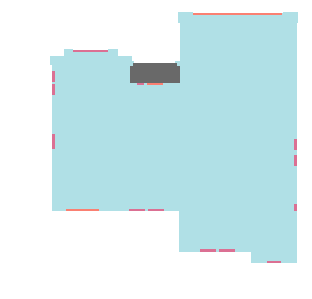

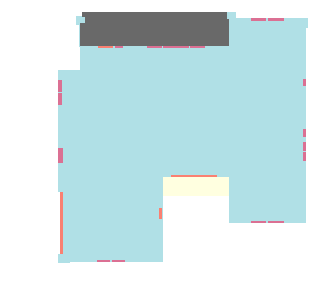

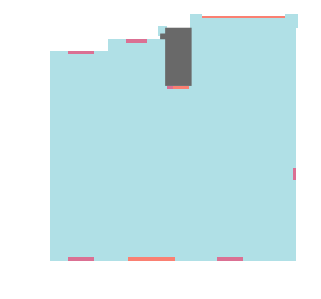

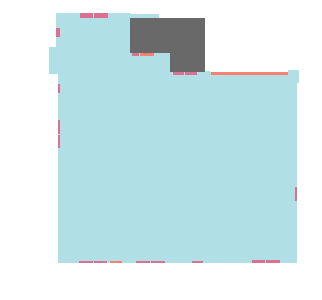

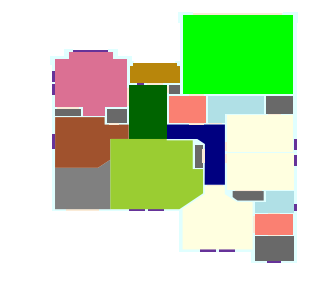

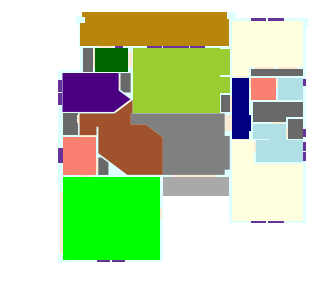

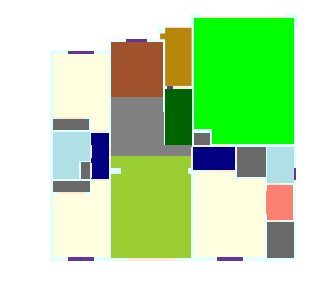

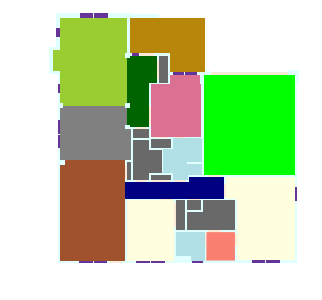

In [150]:
#Corresponding images in a pair {A,B} must be the same size and have 
# the same filename, e.g., /path/to/data/A/train/1.jpg is considered 
# to correspond to /path/to/data/B/train/1.jpg
layer2layer('./l2l_dataset/', layergraphs, ('footprint', ), ('exterior', ), 5)
layer2layer('./l2l_dataset/', layergraphs, ('footprint', 'exterior'), ('interior', ), 5)

In [ ]:
#The best thing to do (I think) is to convert each PyPNG row to a 1‑dimensional numpy array, 
#then stack all of those arrays together to make a 2‑dimensional array. A number of features 
#make this surprising compact. Say pngdata is the row iterator returned from png.Reader.asDirect(). 
#The following code will slurp it into a 2‑dimensional numpy array:
>>> a = numpy.array([[1,2,3],[4,5,6]], dtype=numpy.uint8)
>>> png.from_array(a, mode="L").save("/tmp/foo.png")
image_2d = numpy.vstack(map(numpy.uint16, pngdata))
image_3d = numpy.reshape(image_2d, (row_count, column_count, plane_count))

image_2d = numpy.reshape(image_3d, (-1, column_count * plane_count))
pngWriter.write(out, image_2d)

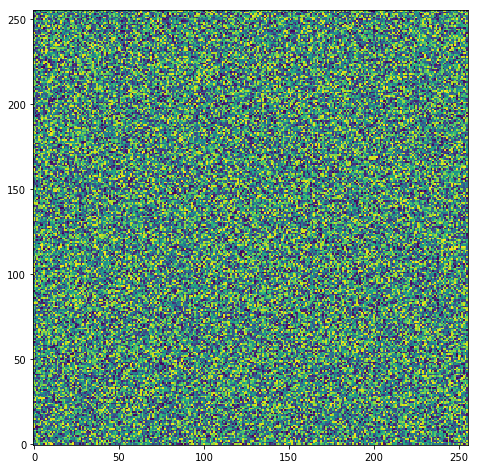

In [44]:

img = np.random.random(size=(256, 256))
img = np.zeros()

f, ax = plot()
ax.imshow(img, origin='lower')


In [43]:
img.min(), img.max()

(1.6467786049023658e-05, 0.9999625143617319)

In [38]:
import png
s = ['110010010011',
     '101011010100',
     '110010110101',
     '100010010011']
s = [[int(c) for c in row] for row in s]


w = png.Writer(len(s[0]), len(s), greyscale=True, bitdepth=1)
f = open('gradient.png', 'wb')
w.write(f, s)
f.close()

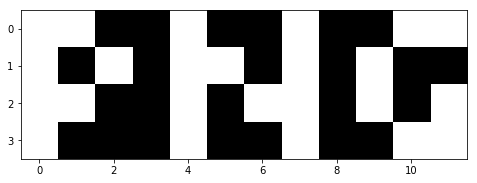

In [39]:
f, ax = plot()
ax.imshow(cv2.imread('./gradient.png'))

In [34]:
!pip install pypng

    100% |████████████████████████████████| 655kB 328kB/s ta 0:00:01
  Running setup.py bdist_wheel for pypng ... done
  Stored in directory: /home/cogle/.cache/pip/wheels/41/6b/ef/0493b536b6d4722c2ae9486691b1d49b922b9877922beeabb3
Successfully built pypng


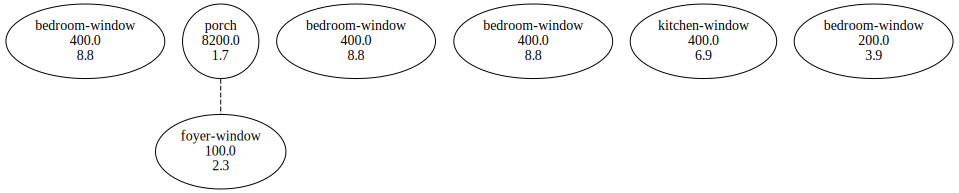

In [16]:
layergraphs[0]['interior'].dot()
layergraphs[0]['exterior'].dot()

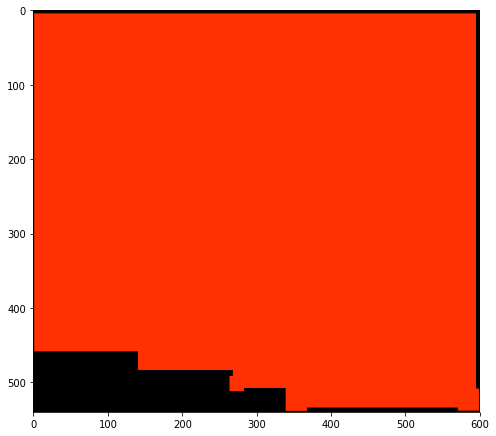

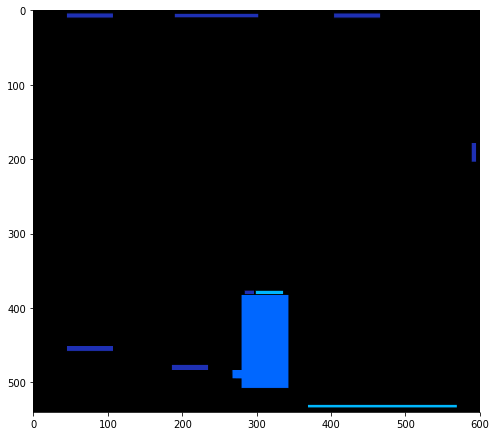

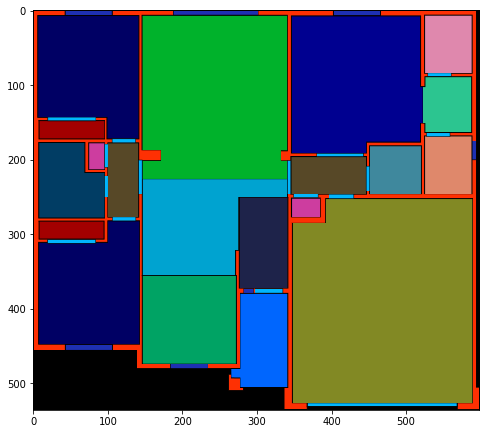

In [30]:
import cv2

img = cv2.imread('./floorplans/011D-0064-floor1-6/011D-0064-floor1-6.footprint.png')
f, ax = plot()
ax.imshow(img)

img = cv2.imread('./floorplans/011D-0064-floor1-6/011D-0064-floor1-6.exterior.png')
f, ax = plot()
ax.imshow(img)

img = cv2.imread('./floorplans/011D-0064-floor1-6/011D-0064-floor1-6.interior.png')
f, ax = plot()
ax.imshow(img)


In [ ]:
svg = './floorplans/011D-0308-floor1-8/011D-0308-floor1-8.svg'
g = parse_floorplan(svg)

In [ ]:
print('exists')
for c in architect.df.columns:
    if c.endswith('exists'):
        print(c)
print('=' * 40)
print('adj')
for c in architect.df.columns:
    if c.endswith('adj'):
        print(c)
print('=' * 40)

In [ ]:
graph = architect.graph()
graph.dot()

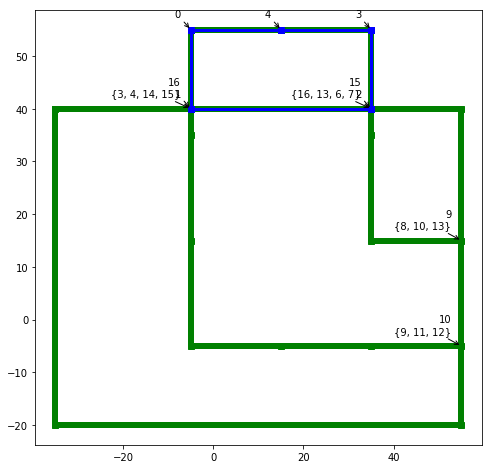

In [4]:
from meshmaker.geometry import bbox

def loop_aspect(loop):
    a, b = bbox(loop)
    dy, dx = (b.y - a.y), (b.x - a.x)
    return dy / dx if dy > dx else dx / dy

def loop_union(l1, l2):
    segs = list(slide(list(l1), 2)) + list(slide(list(l2), 2))
    pg = planargraph(segs=segs)
    union, _ = pg.polygon()
    return union

def loop_difference(l1, l2):
    segs = list(slide(l1, 2)) + list(slide(l2, 2))
    pg = planargraph(segs=segs)
    _, iloops = pg.polygon()
    parts = []
    for loop in iloops:
        for p in loop:
            if not p.inbxy(l2, True):
                parts.append(loop)
                break
    return parts

def loop_intersection(l1, l2):
    segs = list(slide(l1, 2)) + list(slide(l2, 2))
    pg = planargraph(segs=segs)
    _, iloops = pg.polygon()
    for loop in iloops:
        print(loop)
        for p in loop:
            #if p.inbxy(l1, True) and p.onbxy(l2, True):
            #    continue
            #elif p.onbxy(l1, True) and p.inbxy(l2, True):
            #    continue
            if (p.inbxy(l1, True) and p.inbxy(l2, True)):
                continue
            else:
                f, ax = plot()
                plot_loop(ax, l1, col='g')
                plot_loop(ax, l2, col='b')
                plot_point(ax, p, mk='*')
                break
        else:
            return loop



def test():
    l1, l2 = vec3(-1, -1, 0).ring(4, 4), vec3(1, 1, 0).ring(4, 4)
    
    
    segs = list(slide(l1, 2)) + list(slide(l2, 2))
    pg = planargraph(segs=segs)
    
    f, ax = plot()
    plot_pg(ax, pg, lw=6, col='g', mk='s')

    union = loop_union(l1, l2)
    plot_loop(ax, union, lw=3, col='b', mk='s')

    f, ax = plot()
    plot_pg(ax, pg, lw=6, col='g', mk='s')
    
    diff = loop_difference(l1, l2)
    for d in diff:
        plot_loop(ax, d, lw=3, col='b', mk='s')

    f, ax = plot()
    plot_pg(ax, pg, lw=6, col='g', mk='s')
    
    #isect = loop_intersection(l1, l2)
    #plot_loop(ax, isect, lw=3, col='b', mk='s')
    
def test_diff():
    l1 = [vec3(15.0000, -5.0000, 0.0000), vec3(-5.0000, -5.0000, 0.0000), vec3(-5.0000, 15.0000, 0.0000), vec3(-5.0000, 35.0000, 0.0000), vec3(-5.0000, 55.0000, 0.0000), vec3(15.0000, 55.0000, 0.0000), vec3(35.0000, 55.0000, 0.0000), vec3(35.0000, 35.0000, 0.0000), vec3(35.0000, 15.0000, 0.0000), vec3(55.0000, 15.0000, 0.0000), vec3(55.0000, -5.0000, 0.0000), vec3(35.0000, -5.0000, 0.0000)]
    l2 = [vec3(55.0000, -20.0000, 0.0000), vec3(55.0000, 40.0000, 0.0000), vec3(-35.0000, 40.0000, 0.0000), vec3(-35.0000, -20.0000, 0.0000)]

    segs = list(slide(l1, 2)) + list(slide(l2, 2))
    pg = planargraph(segs=segs)
    
    f, ax = plot()
    plot_pg(ax, pg, lw=6, col='g', mk='s')
    
    diff = loop_difference(l1, l2)
    for d in diff:
        plot_loop(ax, d, lw=3, col='b', mk='s')

#test()
test_diff()

In [ ]:
class FakeArchitecturalDataset:

    def __iter__(self):
        for i in range(len(self)):
            yield self[i + 1]

    def __getitem__(self, i):
        return getattr(self, f'sample_{i}')()
    
    def __len__(self):
        return 5
    
    @staticmethod
    def sample_1():
        g = BuildingGraph()
        ex = g.an(rtype='exterior', aspect=None, area=None)
        r1 = g.an(rtype='foyer', aspect=1.0, area=100)
        r2 = g.an(rtype='bath', aspect=1.0, area=40)
        r3 = g.an(rtype='laundry', aspect=1.0, area=40)
        r4 = g.an(rtype='pantry', aspect=1.0, area=40)
        r5 = g.an(rtype='hall', aspect=1.0, area=40)
        r6 = g.an(rtype='kitchen', aspect=1.0, area=40)
        r7 = g.an(rtype='dining', aspect=1.0, area=80)
        r8 = g.an(rtype='living', aspect=1.0, area=80)
        e1 = g.ae(ex, r1, ptype='door')
        e1 = g.ae(r1, r5, ptype='open')
        e2 = g.ae(r5, r2, ptype='door')
        e3 = g.ae(r5, r3, ptype='door')
        e3 = g.ae(r5, r4, ptype='door')
        e3 = g.ae(r5, r6, ptype='door')
        e3 = g.ae(r1, r8, ptype='door')
        e3 = g.ae(r7, r8, ptype='open')
        return g

    @staticmethod
    def sample_2():
        g = BuildingGraph()
        ex = g.an(rtype='exterior', aspect=None, area=None)
        r1 = g.an(rtype='foyer', aspect=1.0, area=100)
        r2 = g.an(rtype='bath', aspect=1.0, area=40)
        r3 = g.an(rtype='laundry', aspect=1.0, area=40)
        r4 = g.an(rtype='pantry', aspect=1.0, area=40)
        r5 = g.an(rtype='hall', aspect=1.0, area=40)
        r6 = g.an(rtype='kitchen', aspect=1.0, area=60)
        r8 = g.an(rtype='living', aspect=1.0, area=100)
        e1 = g.ae(ex, r1, ptype='door')
        e1 = g.ae(r1, r5, ptype='open')
        e2 = g.ae(r5, r2, ptype='door')
        e3 = g.ae(r5, r3, ptype='door')
        e3 = g.ae(r5, r4, ptype='door')
        e3 = g.ae(r5, r6, ptype='door')
        e3 = g.ae(r1, r8, ptype='door')
        return g


    @staticmethod
    def sample_3():
        g = BuildingGraph()
        ex = g.an(rtype='exterior', aspect=None, area=None)
        r1 = g.an(rtype='foyer', aspect=1.0, area=60)
        r2 = g.an(rtype='bath', aspect=1.0, area=40)
        r4 = g.an(rtype='pantry', aspect=1.0, area=40)
        r6 = g.an(rtype='kitchen', aspect=1.0, area=80)
        r8 = g.an(rtype='living', aspect=1.0, area=90)
        e1 = g.ae(ex, r1, ptype='door')
        e1 = g.ae(r1, r8, ptype='open')
        e2 = g.ae(r8, r2, ptype='door')
        e3 = g.ae(r6, r4, ptype='door')
        e3 = g.ae(r8, r6, ptype='door')
        return g


    @staticmethod
    def sample_4():
        g = BuildingGraph()
        ex = g.an(rtype='exterior', aspect=None, area=None)
        r1 = g.an(rtype='foyer', aspect=1.0, area=50)
        r2 = g.an(rtype='bath', aspect=1.0, area=40)
        r3 = g.an(rtype='laundry', aspect=1.0, area=40)
        r4 = g.an(rtype='pantry', aspect=1.0, area=40)
        r5 = g.an(rtype='hall', aspect=1.0, area=40)
        r6 = g.an(rtype='kitchen', aspect=1.0, area=80)
        r8 = g.an(rtype='living', aspect=1.0, area=90)
        e1 = g.ae(ex, r1, ptype='door')
        e1 = g.ae(r1, r5, ptype='open')
        e2 = g.ae(r5, r2, ptype='door')
        e3 = g.ae(r5, r3, ptype='door')
        e3 = g.ae(r6, r4, ptype='door')
        e3 = g.ae(r5, r6, ptype='door')
        e3 = g.ae(r6, r8, ptype='open')
        return g
    

    @staticmethod
    def sample_5():
        g = BuildingGraph()
        ex = g.an(rtype='exterior', aspect=None, area=None)
        r1 = g.an(rtype='foyer', aspect=1.0, area=50)
        r2 = g.an(rtype='bath', aspect=1.0, area=40)
        r3 = g.an(rtype='laundry', aspect=1.0, area=40)
        r4 = g.an(rtype='pantry', aspect=1.0, area=40)
        r5 = g.an(rtype='hall', aspect=1.0, area=40)
        r6 = g.an(rtype='kitchen', aspect=1.0, area=90)
        r8 = g.an(rtype='living', aspect=1.0, area=80)
        e1 = g.ae(ex, r1, ptype='door')
        e1 = g.ae(r1, r5, ptype='open')
        e2 = g.ae(r5, r2, ptype='door')
        e3 = g.ae(r5, r3, ptype='door')
        e3 = g.ae(r6, r4, ptype='door')
        e3 = g.ae(r5, r6, ptype='door')
        e3 = g.ae(r1, r8, ptype='door')
        return g

# features

    for each sample
    
        total area
        
        foot print
    
    for each room type
    
        total area
        
        bbox aspect ratio
        
        room type
        
    for each room adjacency
       
        non-adjacent, door, or open

In [ ]:
                   
def test():
    segs = (
        (vec3(-10, 0, 0), vec3(5, 0, 0)),
        (vec3(-5, 0, 0), vec3(10, 0, 0))
    )
    pg = planargraph(segs=segs)
    
    f, ax = plot()
    plot_pg(ax, pg, lw=3, col='g', mk='s')
    
    pg.dissolve()

    f, ax = plot()
    plot_pg(ax, pg, lw=3, col='g', mk='s')
    
    
test()

In [ ]:
from meshmaker.geometry import graham_scan
    
def test():
    data = np.random.random((150, 2))
    points = [vec3(x, y, 0) for x, y in data]
    
    hull = graham_scan(points)
    
    f, ax = plot()
    for p in points:
        plot_point(ax, p, mk='*', col='r')
    plot_loop(ax, hull, lw=3, col='g')
    
test()

In [ ]:
import xml.etree.ElementTree as ET
import collections
from meshmaker.vec3 import vec3
from meshmaker.geometry import sintsxyp, slide


class ParseFloorplan:

    @classmethod
    def parse_loop(cls, e):
        x = next(e.iter(tag='polygon'))
        l = x.attrib.get('points').split(' ')[:-1]
        l = [p.split(',') for p in l]
        return [vec3(round(float(x), 0), round(float(y), 0), 0) for x, y in l]

    @classmethod
    def parse_node(cls, e):
        nodeclass = e.attrib.get('class')
        nodetype = nodeclass.split()
        loop = cls.parse_loop(e)
        return dict(nodetype=nodetype, loop=loop)

    @classmethod
    def parse_wall(cls, e):
        node = cls.parse_node(e)
        doors, windows = [], []
        for x in e:
            c = x.attrib.get('class')
            if c is None:
                pass
            elif c.startswith('Door'):
                doors.append(cls.parse_node(x))
            elif c.startswith('Window'):
                windows.append(cls.parse_node(x))
            else:
                print(c.attrib, c.tag)
        node['doors'] = doors
        node['windows'] = windows
        return node
    
    @classmethod
    def parse_floor(cls, e):
        parts = collections.defaultdict(list)
        pmap = {c:p for p in e.iter() for c in p}
        for x in e.iter(tag='polygon'):
            y = pmap[x]
            if y.tag == 'marker':
                continue
            c = y.attrib.get('class')
            if c.startswith('Space'):
                parts['spaces'].append(cls.parse_node(y))
            elif c.startswith('Wall'):
                parts['walls'].append(cls.parse_wall(y))
            #else:
            #    print(c, y.tag)
        return parts        
    
    @staticmethod
    def segs_overlap(a, b, c, d, e=10000):
        x = c.insxy(a, b, e=e)
        y = d.insxy(a, b, e=e)
        w = a.insxy(c, d, e=e)
        z = b.insxy(c, d, e=e)
        return ([x, y, w, z].count(True) > 1)
    
    @classmethod
    def loops_adjacent(cls, l1, l2):        
        for u, v in slide(l1, 2):
            if u.isnear(v):
                continue
            for p, q in slide(l2, 2):
                if p.isnear(q):
                    continue
                
                if cls.segs_overlap(u, v, p, q):
                    return True
                
                #ip = sintsxyp(u, v, p, q)
                #if isinstance(ip, tuple) or isinstance(ip, list):
                #    return ip

    @classmethod
    def graph_floor(cls, floor):
        g = Graph()
        ext = g.an(loop=[], rtype='exterior', aspect=1, area=1)
        for x in floor['spaces']:
            nodetype = x['nodetype'][1].lower()
            nodetype = cls.typemap.get(nodetype, nodetype)
            g.an(loop=x['loop'], rtype=nodetype, aspect=1.0, area=10)
        for x in floor['walls']:
            for y in x['doors']:
                adjs = []
                for i, z in enumerate(g.nodes):
                    if cls.loops_adjacent(z.loop, y['loop']):
                        adjs.append(i)
                else:
                    if len(adjs) == 1:
                        g.ae(ext, adjs[0], ptype='door')
                    elif len(adjs) == 2:
                        g.ae(*adjs, ptype='door')
                    else:
                        #print('addjjjs', adjs, y)
                        raise ValueError
        for i, x in enumerate(g.nodes):
            for j, y in enumerate(g.nodes):
                if j < i:
                    if cls.loops_adjacent(x.loop, y.loop):
                        #g.ae(i, j, ptype='open')
                        g.ae(i, j, ptype='door')
        return g

    '''
    typemap = {
        'userdefined': 'room',
        'undefined': 'room',
        'alcove': 'room',
        'dressingroom': 'room',
        'utility': 'closet',
        'storage': 'closet',
        'technicalroom': 'closet',
        'draughtlobby': 'entry',
        'carport': 'room',
        'garbage': 'room',
        'garage': 'room',
        'den': 'living',
        'livingroom': 'living',
        'library': 'room',
        'exerciseroom': 'room',
        'recreationroom': 'room',
        'retailspace': 'room',
        'elevated': 'room',
        'hall': 'room',
        'sauna': 'closet',
        #'dining': 'kitchen',
        'office': 'room',
    }
    typebudget = {
        'kitchen': 1,
        'garage': 1,
        'outdoor': 1,
        'living': 1,
        'entry': 1,
        'dining': 1,
        'room': 1,
        'closet': 1,
        'bedroom': 1,
        'bath': 1,
    }
    adjtypemap = {
        'none': 0,
        'open': 1,
        'door': 1,
    }
    
    @classmethod
    def map_nodetypes(cls, g):
        mapping = {}
        seen = collections.defaultdict(lambda : 0)
        for i, n in enumerate(g.nodes):
            if len(g.nrings[i]) > 0:
                ntype = f'{n.rtype.lower()}'
                ntype = cls.typemap.get(ntype, ntype)
                seen[ntype] += 1
                if seen[ntype] > cls.typebudget.get(ntype, 5):
                    raise ValueError(f'too many {ntype}s')
                mapping[i] = f'{ntype}-{seen[ntype]}'
        return mapping

    @classmethod
    def features(cls, g):
        """
        Feature Domain
        ---
        Total Square Footage Z
        Footprint Z × Z
        Room {bed, bath, . . . }
        Per-room Area Z
        Per-room Aspect Ratio Z × Z
        Room to Room Adjacency {true, false}
        Room to Room Adjacency Type {open-wall, door}
        """
        mapping = cls.map_nodetypes(g)
        features = collections.defaultdict(lambda : 0)
        for i, n in enumerate(g.nodes):
            if len(g.nrings[i]) > 0:
                features[f'{mapping[i]}->exists'] = 1
                if not 'exterior' in mapping[i]:
                    #pass
                    features[f'{mapping[i]}->area'] = n.area
                    features[f'{mapping[i]}->aspect'] = n.aspect
        for i, e in enumerate(g.edges):
            u, v = sorted((mapping[e.u], mapping[e.v]))
            features[f'{u},{v}->adj'] = cls.adjtypemap[e.ptype]
        return features
    '''
    
    def __new__(cls, path):
        tree = ET.parse(path)
        root = tree.getroot()
        for x in root.iter():
            x.tag = x.tag.replace('{http://www.w3.org/2000/svg}', '')
        height = root.attrib['height']
        width = root.attrib['width']
        viewbox = root.attrib['viewBox']
        floors = []
        for x in root.findall('.'):
            #print(x.attrib, x.tag)
            for y in x.find('g'):
                c = y.attrib.get('class')
                if c == 'Floor':
                    parsed = cls.parse_floor(y)
                    graphed = cls.graph_floor(parsed)
                    features = cls.features(graphed)
                    floors.append((parsed, graphed, features))
                elif c == 'FloorsCompose':
                    pass
                    #print('floorscompose', y.attrib, y.tag)
                    #for z in y:
                    #    print('floorscompose', z.attrib, z.tag)
        return floors

In [ ]:
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import numpy as np
import os


class CubiCasa5k:
    
    def prune(self, df, max_n_features=35):
        
        n_samples, n_features = df.shape
        print('pruned', n_samples, n_features)
        
        while n_features > max_n_features:
            
            fracs = []
            for i, c in enumerate(df.columns):
                f = df[c].value_counts()[1.0] / len(df)
                fracs.append((i, f))
            which = sorted(fracs, key=(lambda x: x[0]))[0][0]
            df = df[~(df[df.columns[which]] == 1)]
            
            drop = []
            for i, c in enumerate(df.columns):
                if (df[c] == 0).all():
                    drop.append(c)
            df = df.drop(labels=drop, axis=1)
            n_samples, n_features = df.shape
            
            print('pruned', n_samples, n_features)
        return df
    
    def __init__(self, root):
        samples = []
        with tqdm(total=5000) as pbar:
            for r, ds, fs in os.walk(root):
                for f in filter(lambda fn: fn == 'model.svg', fs):
                    pbar.update(1)
                    svg = os.path.join(r, f)        
                    try:
                        floors = ParseFloorplan(svg)
                        if len(floors) == 1:
                            samples.append(floors[0][2])
                        #for _, _, floor in floors:
                        #    samples.append(floor)
                    except KeyboardInterrupt:
                        raise
                    except:
                        pass
                        #raise
        features = list(sorted(set.union(*samples)))
        feature_mapping = {f: i for i, f in enumerate(features)}
        n_features = len(features)
        print(f'successfully parsed {len(samples)} samples')
        print(f'found {n_features} features')
        
        dfsamples = []
        for s in samples:
            x = np.zeros(n_features, dtype=np.int16)
            for f in s:
                x[feature_mapping[f]] = 1
            dfsamples.append(x)
        df = pd.DataFrame(dfsamples, columns=features)
        #self.df = df
        self.df = self.prune(df)        
        
    def __getitem__(self, i):
        return self.df[i]

    def __len__(self):
        return len(self.df)
        
dataset = CubiCasa5k('/home/cogle/dev/cubicasa5k/high_quality_architectural/')

In [ ]:
from graphviz import Digraph


def house_graph():
    rooms = ['kitchen', 'living', 'bed', 'bath', 'office']

    g = Digraph(comment='', engine=None)
    g.node('total area', 'total area')
    g.node('footprint', 'footprint')
    g.edge('total area', 'footprint')

    for i, u in enumerate(rooms):
        g.node(f'{i}', f'{u}-exists')
        g.node(f'{i}ar', f'{u} area')
        g.node(f'{i}as', f'{u} aspect')
        g.edge(f'{i}ar', f'{i}as')
        g.edge('total area', f'{i}')
        for j, v in enumerate(rooms):
            if j < i:
                g.node(f'{rooms.index(u)}{rooms.index(v)}e', f'{u}-{v} adj-exists')
                g.edge(f'{rooms.index(u)}', f'{rooms.index(u)}{rooms.index(v)}e')
                g.edge(f'{rooms.index(v)}', f'{rooms.index(u)}{rooms.index(v)}e')
                g.node(f'{rooms.index(u)}{rooms.index(v)}t', f'{u}-{v} adj-type')
        
    g.edge(f'{rooms.index("kitchen")}', f'{rooms.index("living")}ar')
    g.edge('total area', f'{rooms.index("living")}{rooms.index("kitchen")}t')
    
    return g


house_graph()    

In [ ]:
%matplotlib notebook
from IPython.display import SVG, Image, display
from IPython.display import Image
import os
from meshmaker.plt import *


def check_sample(path):
    #display(Image(filename=os.path.join(path, 'F1_scaled.png')))
    svg = os.path.join(path, 'model.svg')
    floors = ParseFloorplan(svg)
    #display(SVG(svg))
    
    f, ax = plot()
    segs = []
    floor = 0

    print(floors[floor][2])
    
    for x in floors[floor][0]['walls']:
        for y in x['doors']:
            segs.extend(list(slide(y['loop'], 2)))
            plot_loop(ax, y['loop'], lw=3, col='r')
        #for y in x['windows']:
        #    segs.extend(list(slide(y['loop'], 2)))
        #    plot_loop(ax, y['loop'], lw=1, col='b')
    for x in floors[floor][0]['spaces']:
        segs.extend(list(slide(x['loop'], 2)))
        plot_loop(ax, x['loop'], lw=1)
        plot_point(ax, vec3.com(x['loop']), annotation=x['nodetype'][1])    
    
    return floors[floor][1].dot()


check_sample('/home/cogle/dev/cubicasa5k/high_quality_architectural/9055/')

In [ ]:
def test_dedupe():
    #segs = list(slide(vec3.O().ring(4, 4, False), 2)) +\
    #       list(slide(vec3(0, 8, 0).ring(4, 4, False), 2))
    #pg = planargraph(segs=segs)
    pg = planargraph(segs=((vec3(-10, 0, 0), vec3(10, 0, 0)), (vec3(0, -10, 0), vec3(0, 10, 0))))
    pg.ne(pg.nv(vec3(5, 5, 0)), pg.nv(vec3(5, -5, 0)))
    pg.ne(pg.nv(vec3(5, 2, 0)), pg.nv(vec3(5, -8, 0)))
    #for n, v in enumerate(pg.vertices):
    #    if v is not None:
    #        v.properties['annotation'] = ' '

    f, ax = plot()
    plot_pg(ax, pg, mk='o', annotate=True)
    
    split_vertex(pg, 4, 3 * np.pi / 4)

    pg.vertices[4].trn(vec3.Y() * -2)
    
    f, ax = plot()
    plot_pg(ax, pg, mk='o', annotate=True)

    pg.vertices[4].trn(vec3.Y() * 2)

    f, ax = plot()
    plot_pg(ax, pg, mk='o', annotate=True)
    
    dedupe_pg(pg)

    f, ax = plot()
    plot_pg(ax, pg, mk='o', annotate=True)
    
    
test_dedupe()